### 주요내용
- 딥러닝의 네트워크가 깊고 레이어가 넓을 수록 성능이 높아지는 것은 이미 증명됨.
    -> 하지마 이럴 경우 Vanishing 문제와 Overfitting 문제가 생김

- 1 by 1 커널을 이용하여 channel에 대한 dimension reduction방법을 이용하여 매우 deep한 모델을 훈련
- 1 by 1 커널의 다양한 해석 제시
    - 1 by 1 을 이용해서 채널을 압축할 경우 정보를 유지하면서 계산의 복잡도를 줄일 수 있다고 주장.
    - 해당 방법에 대해서 ```inception```이라는 표현을 사용
    - `inception`: Optimal local sparse structure가 어떻게 최적화 될 수 있을지 찾아보자.
    
- Deep한 모델들의 conv 연산을 작은 conv연산 조합을 쪼갰다. 
    - 이때 위에서 언급한 1 by 1 커널을 활용함 (특히 5 by 5 커널도 계산상 매우 크다고 주장)
    - network의 전체적으로는 연결을 줄이면서,
    - 내부 행렬 연산에서는 매우 Dense하게 하여 계산을 편리하게 !
    

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class Inception(nn.Module):
    def __init__(self, in_size, _1by1, _3by3red, _3by3, _5by5_red, _5by5, pool_size):
        super(Inception, self).__init__()
        
        # 1 by 1 branch
        self.case1 = nn.Sequential(
            nn.Conv2d(in_size, _1by1, kernel_size=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU())
        
        # 1 by 1 to 3 by 3 branch
        self.case2 = nn.Sequential(
            nn.Conv2d(in_size, _3by3red, kernel_size=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU(),
            nn.Conv2d(_3by3red, _3by3, kernel_size=3, padding=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU())
        
        # 1by1 to 5by5 branch
        self.case3 = nn.Sequential(
            nn.Conv2d(in_size, _5by5_red, kernel_size=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU(),
            nn.Conv2d(_5by5_red, _5by5, kernel_size=5, padding=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU())
        
        # maxpooling to 1by1 branch
        self.case4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_size, pool_size, kernel_size=1),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.ReLU())
        
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)
            

class GoogLeNet(nn.Module):
    def __init__(self, image_shape, n_classes=10):
        super(GoogLeNet, self).__init__()
        
        # from input to the first softmax
        self.prev = nn.Sequential(
            nn.Conv2d(image_shape[0], 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self._1st_phase = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32),     # 3a 
            Inception(256, 128, 192, 32, 32, 96, 64),     # 3b  --> output 480 channle
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)   
        )
        
        self._2nd_phase = nn.Sequential(
            Inception(480, 192, 96, 208, 16, 48, 64),    # 4a 
            Inception(512, 160, 112, 224, 24, 64, 64),   # 4b
            Inception(512, 128, 128, 256, 24, 64, 64),   # 4c
            Inception(512, 112, 144, 288, 32, 64, 64),   # 4d
            Inception(528, 256, 160, 320, 32, 128, 128), # 4e  --> output 832 channel
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self._3rd_phase = nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128),  # 5a
            Inception(832, 384, 192, 384, 48, 128, 128),  # 5b
            nn.AvgPool2d(kernel_size=8, stride=1)                   
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1024, 1000)
        )
    
    def forward(self, x):
        out = self.prev(x)
        out = self._1st_phase(out)
        out = self._2nd_phase(out)
        out = self._3rd_phase(out)
        out = self.fc(out)
        return out
            
        

In [3]:
net = GoogLeNet((3, 256, 256))
net

GoogLeNet(
  (prev): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_1st_phase): Sequential(
    (0): Inception(
      (case1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
        (2): ReLU()
      )
      (case2): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
        (2): ReLU()
        (3): Conv2d(96, 128, ker

### AVG Pooling
- https://kevinthegrey.tistory.com/142


- `Max pooling`의 경우  stride와 window size를 지정해준 다음 각 커널이 만들어둔 feature map마다 이동하면서 window 크기중max값을 뽑아낸다. 결국 channel은 줄어들지 않고 x와 y의 크기만 줄어든다.


- `Avg pooling`의 경우 stride와 window size가 필요없으며, 각 feature map마다 해당 feature map의 평균 값을 뽑아낸다.


사진으로 비교하면 다음과 같다.


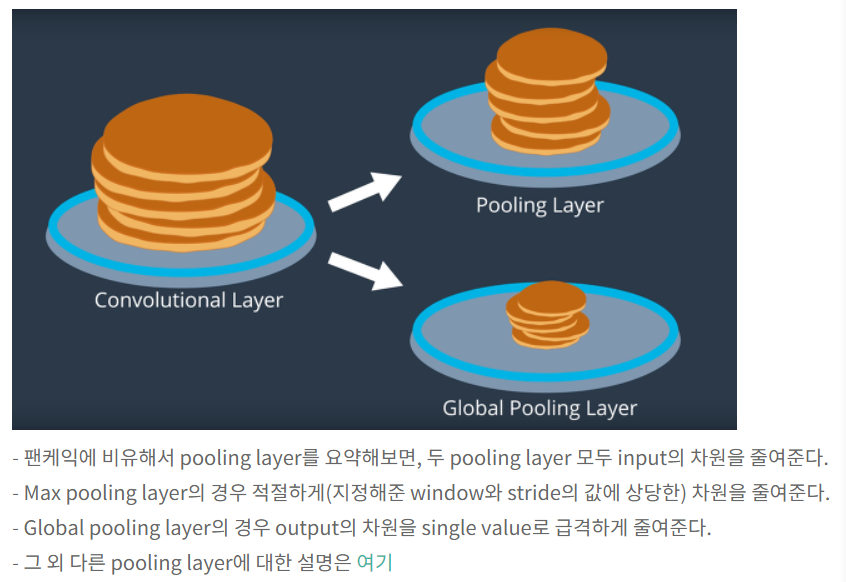

### Reference

- https://datascienceschool.net/view-notebook/8d34d65bcced42ef84996b5d56321ba9/
- https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py